# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

Before submit, check review here: https://review.udacity.com/#!/rubrics/1973/view

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as p
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [4]:
# Take a look at the head of the feat_info data
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
# check some statistics
feat_info.describe(include='all')

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ANZ_PERSONEN,person,ordinal,[-1]
freq,1,43,49,26


In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
azdias.describe(include=['O'])

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
count,798073,792242,792242,792242
unique,2,10,45,22
top,W,8,6B,51
freq,629528,134441,56672,133694


In [9]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [10]:
# check which columns has missing values
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### Identify missing or unknown data values and convert them to NaNs.

In [12]:
feature = feat_info.iloc[:,0]
missing_value_codes = feat_info.iloc[:,3]

In [13]:
missing_value_codes.head()

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
Name: missing_or_unknown, dtype: object

In [14]:
len(missing_value_codes)

85

In [15]:
b = "[]"
missing_value_list = []
for i in range(len(missing_value_codes)):
    for char in b: 
        missing_value_codes[i] = missing_value_codes[i].replace(char,"")
        c = missing_value_codes[i].split(',')
    
    missing_value_list.append(c)

len(missing_value_list)

85

In [16]:
# check one record to see if it return a list
missing_value_list[59]

['-1', 'XX']

In [17]:
# change the data type to float
for i in range(len(feat_info)):
    if azdias.iloc[:,i].dtype == 'int64':
        azdias.iloc[:,i] = azdias.iloc[:,i].astype(float)

In [18]:
# replace nan for columns
for i in range(len(feat_info)):
    if (azdias.iloc[:,i].dtype == float) and (missing_value_list[i] !=['']):
        c = [float(j) for j in missing_value_list[i]]
        azdias.iloc[:,i] = azdias.iloc[:,i].replace(c, np.nan)
    else:
        c = [str(j) for j in missing_value_list[i]]
        azdias.iloc[:,i] = azdias.iloc[:,i].replace(c, np.nan)

In [19]:
# check if the missing value match with feat_info is replace with NaN
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
# replace any empty value to NaNs
azdias = azdias.fillna(np.nan)

In [21]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the dataset.
num_nans = pd.Series(data = azdias.isnull().sum(), name = 'num_nans')
num_nans = num_nans.sort_values(ascending=True)

In [23]:
# check top ten missing value columns
num_nans.sort_values(ascending=False)[:10]

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
REGIOTYP          158064
KKK               158064
W_KEIT_KIND_HH    147988
KBA05_ANTG3       133324
Name: num_nans, dtype: int64

In [24]:
# check how many columns have missing values
len(num_nans[num_nans > 0])

61

### Investigate patterns in the amount of missing data in each column.

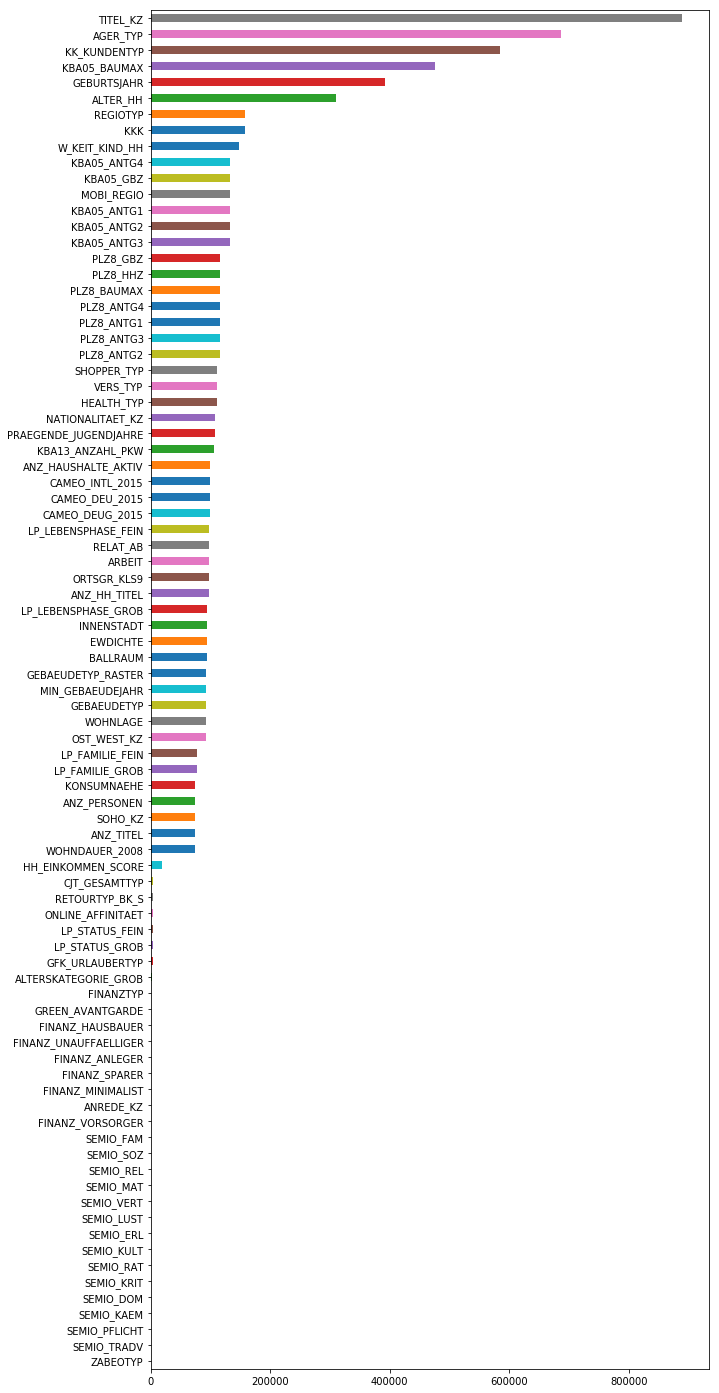

In [25]:
# plot missing values for each columns
plt.figure(figsize=(10,25))
num_nans.plot.barh()

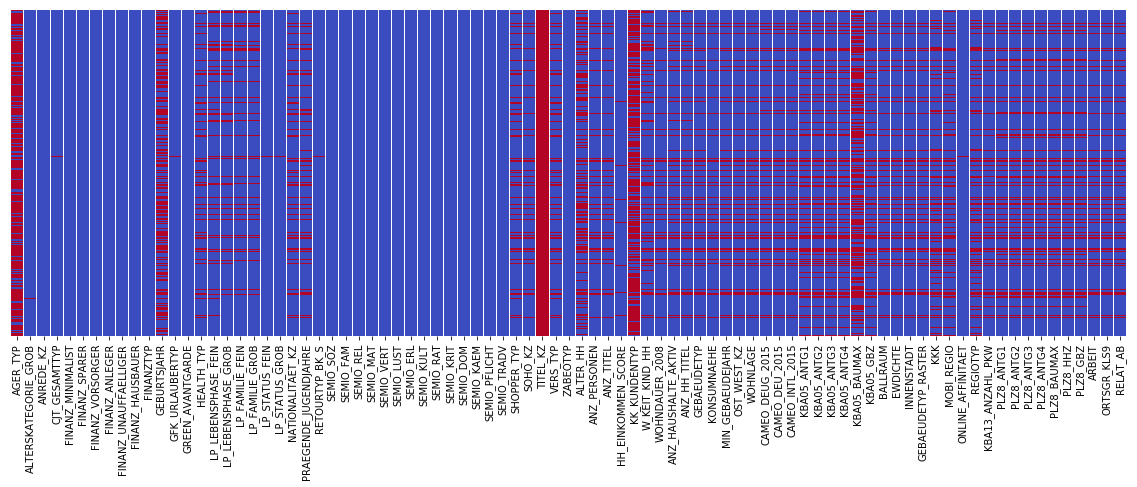

In [26]:
plt.figure(figsize=(20,6))
sns.heatmap(data = azdias.isnull(),yticklabels=False, cbar=False, cmap = 'coolwarm')

When we compare this heatmap with the calcualtion we got from the previous part, we confirm that they are both matched. The top 6 missing value columns are:
- TITEL_KZ(Academic title flag, such as Dr., Prof.):                889061
- AGER_TYP(Best-ager typology, such as passive elderly, cultural elderly):                685843
- KK_KUNDENTYP(Consumer pattern over past 12 months):            584612
- KBA05_BAUMAX(Most common building type within the microcell):            476524
- GEBURTSJAHR(Year of birth):             392318
- ALTER_HH(Birthdate of head of household):                310267

We can see from aboved that there are some columns have many NaNs. I'd like to see the NaNs percentage for each column.

In [27]:
# create an empty list to see the missing value portion for each column
missing_dict = {}

# loop through each feature, calculate the missing portion for each feature = # of null / total records in each feature
for i in range(len(azdias.columns)):
    missing_dict[azdias.columns[i]] = (azdias[azdias.columns[i]].isnull().sum()) / len(azdias[azdias.columns[i]])

In [28]:
# put the dictionary into a dataframe for better illustration
s = pd.Series(missing_dict, name='missing_portion')

In [29]:
# check which columns have the highest missing value
# sort the missing portion part by descending
s.sort_values(ascending=False)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

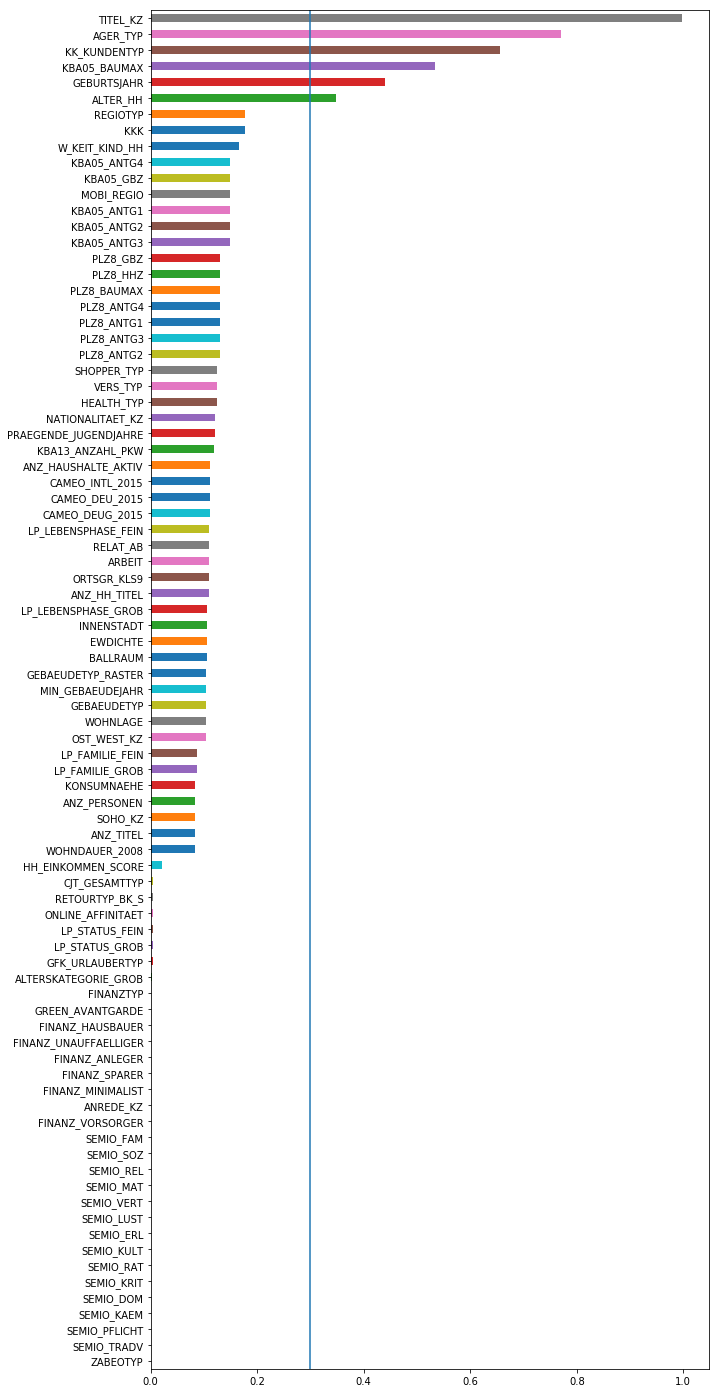

In [30]:
plt.figure(figsize=(10,25))
s.sort_values(ascending=True).plot.barh()
plt.axvline(x=0.3)

When we compare this heatmap with the calcualtion we got from the previous part, we confirm that they are both matched. The top 6 missing value columns are: 
- TITEL_KZ = 0.997576
- AGER_TYP = 0.769554
- KK_KUNDENTYP = 0.655967
- KBA05_BAUMAX = 0.534687
- GEBURTSJAHR = 0.440203
- ALTER_HH = 0.348137

In [31]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# as we can see from the above data, there are 6 columns have missing values more than 30%. I'm going to delete
# these 6 columns

drop_cols = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

# drop those columns in azdias datast
azdias = azdias.drop(drop_cols,axis = 1)
# check if the columns were drop 
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STAT

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 85 feateurs, 61 of them have missing values. Amount all the features, there are 6 features that have missing values more than 30%. I removed these 6 columns: 
- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

### How much data is missing in each row of the dataset?

Text(0.5,1,'Distribution for Missing Value (in count) in Each Row')

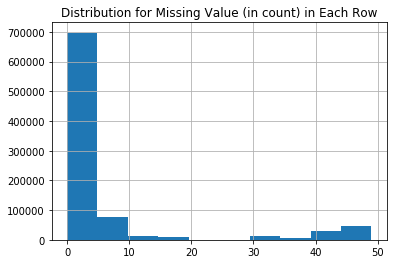

In [32]:
# step 1: get number of missing values in each row
row_nans = pd.Series(data = azdias.isnull().sum(axis=1), name = 'num_nans')
row_nans.hist()
plt.title("Distribution for Missing Value (in count) in Each Row")

Text(0.5,1,'Distribution for Missing Value (in Percentage) in Each Row')

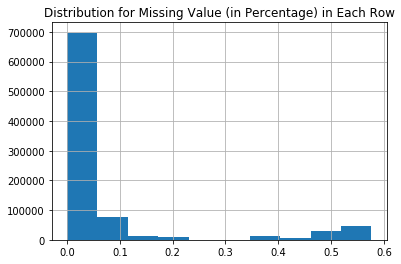

In [33]:
# step 2: get percentage of missing values in each row
row_nans_percent = pd.Series(data = (azdias.isnull().sum(axis=1)/len(feat_info)), name = 'percent_nans')
row_nans_percent.hist()
plt.title("Distribution for Missing Value (in Percentage) in Each Row")

In [34]:
# see how many rows with no missing values at all
# about 69.93% of the rows without missing values
No_miss = round(len(row_nans[row_nans == 0])/len(azdias) * 100,2)
print("Percentage of Row without Missing Value is: {}%".format(No_miss))

Percentage of Row without Missing Value is: 69.93%


In [35]:
len(row_nans[row_nans == 0])

623209

#### Since about 70% of the rows have no missing value in each column, I think it's large enough for me to set the threadhold for how to seperate the data into subsets. I will divide the data into two subsets based on whether the rows have or not have missing values at all.

In [36]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# step 1: append row_nans indicator to azdias dataset
azdias['row_nans_num'] = row_nans

In [37]:
# check if the row_nans_num column is added 
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_nans_num
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [38]:
# step 2: divide dataset into two subsets. 
# One is no missing values in a row, that's row_nans_num == 0
# One is with at least one missing value in a row, that's row_nans_num > 0

def f(row):
    if row['row_nans_num'] == 0:
        val = 'N'
    else:
        val = 'Y'
    return val

azdias['row_nans_id'] = azdias.apply(f, axis=1)

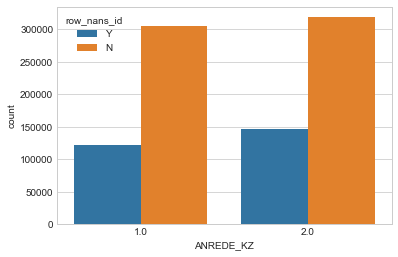

In [39]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
sns.set_style('whitegrid')
sns.countplot(x='ANREDE_KZ',data=azdias, hue = 'row_nans_id')

In [40]:
azdias_no_rownans = azdias[azdias['row_nans_id'] == 'N']
azdias_has_rownans = azdias[azdias['row_nans_id'] == 'Y']

/Users/Jiaqi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


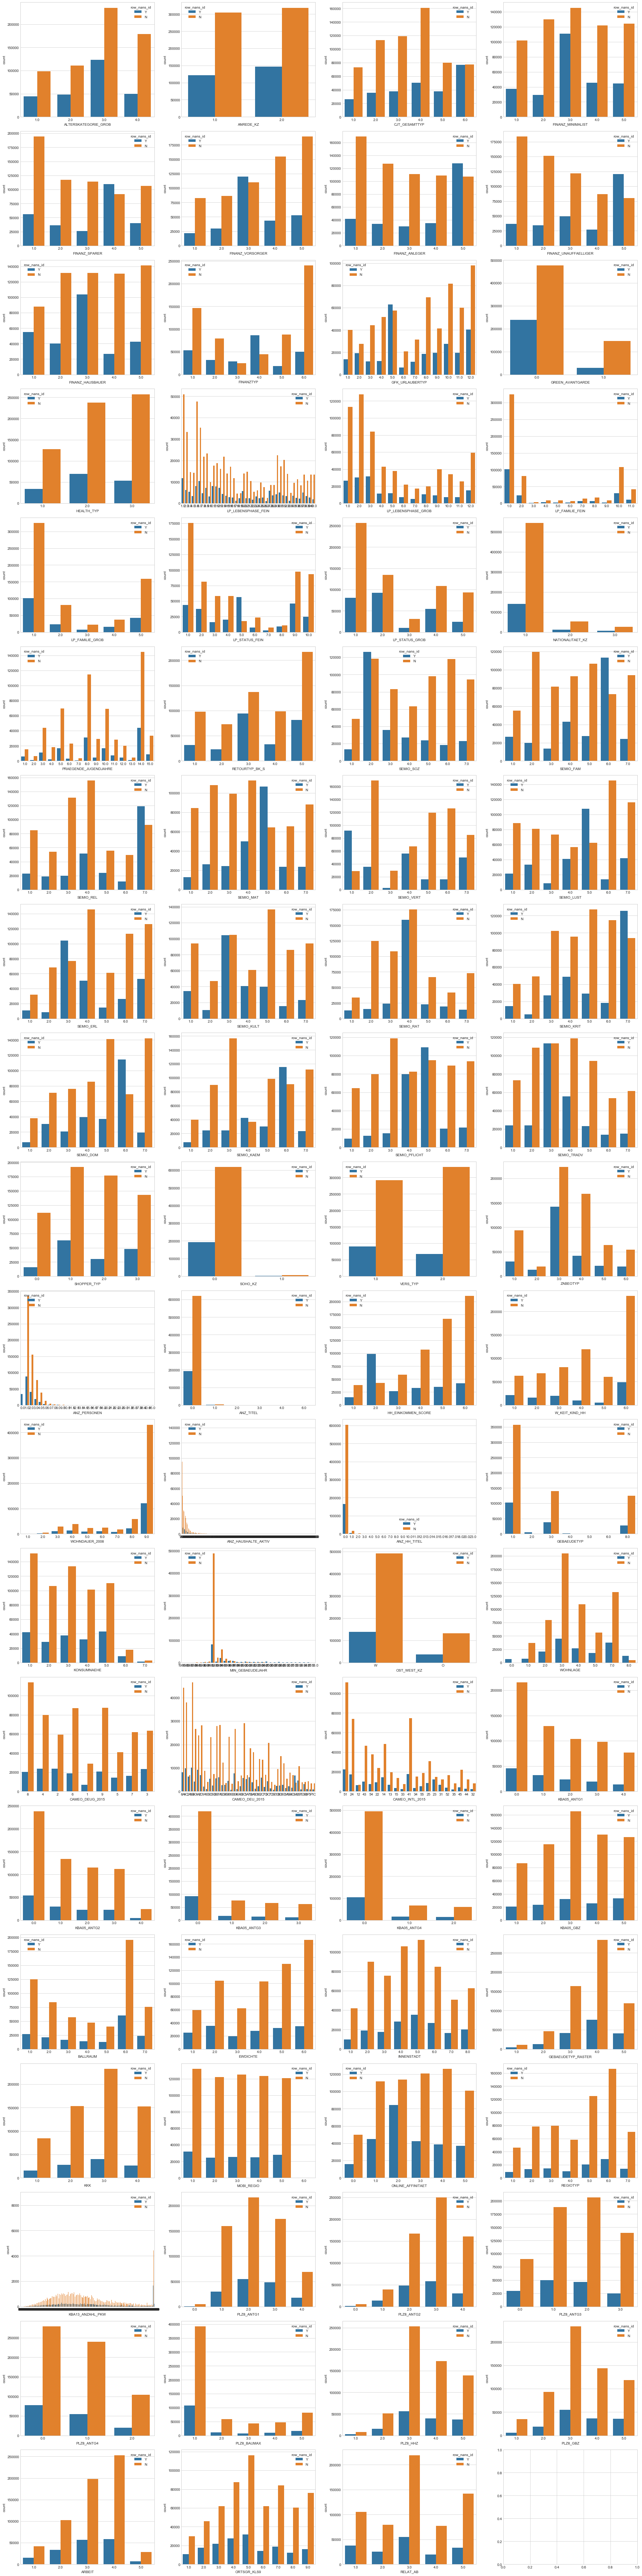

In [41]:
row = 20
col = 4

fig, ax =plt.subplots(nrows=row,ncols=col, figsize = (25,100))

index = 0
for i in range(row):
    for j in range(col):
        if index < (len(azdias.columns) - 2): # I added 2 addtional columns to the origial dataset, should not plot
            sns.countplot(x=azdias.columns[index],data=azdias, hue = 'row_nans_id', ax=ax[i][j])
            index = index + 1

fig.tight_layout()
fig.show()

1. **ALTERSKATEGORIE_GROB:** Similar distribution between NaNs and no Nans dataset
2. **ANREDE_KZ:** Similar distribution between NaNs and no Nans dataset
3. **CJT_GESAMTTYP:** For with NaNs dataset, the top value is 'Advertising-Enthusiast with restricted Cross-Channel-Behaviour'. But for no NaNs dataset, the top value is 'advertisinginterested Online-shopper'. But if we exclude the last value (6 = Advertising-Enthusiast with restricted Cross-Channel-Behaviour). The distributions look similar. 
4. **FINANZ_MINIMALIST:** Distributions look different. With top selection of 3 = avarage in both dataset. But for dataset with NaNs, the second highest selection is 2 = high, while 2 is the lowest selection for dataset without NaNs.  5. **FINANZ_SPARER:** Distributions look different.
6. **FINANZ_VORSORGER:** Distributions look different.
7. **FINANZ_ANLEGER:** Distributions look different. 
8. **FINANZ_UNAUFFAELLIGER:** Distributions look very different 
9. **FINANZ_HAUSBAUER:** Distribution look very different
10. **FINANZTYP:** Distribution look very different 
11. **GFK_URLAUBERTYP:** Slightly different
12. **GREEN_AVANTGARDE:** Similar distribution between NaNs and no Nans dataset 
13. **HEALTH_TYP:** Slightly different, with 1 = critical reserved being the least in both dataset.   
14. **LP_LEBENSPHASE_FEIN:** Similar distributions
15. **LP_LEBENSPHASE_GROB:** Similar distribution, especially for higher range values, Values >= 4. 
16. **LP_FAMILIE_FEIN:** Similar distribution
17. **LP_FAMILIE_GROB:** Similar distribution
18. **LP_STATUS_FEIN:**  Distributions look different. For dataset with NaNs, the top category is 5 = minimalistic high-income earners, but for dataset with no NaNs, the top category is typical low-income earners. Looks like we have more incomplete data for minimalistic higher-income earners. 
19. **LP_STATUS_GROB:** Slightly different
20. **NATIONALITAET_KZ:** Similar
21. **PRAEGENDE_JUGENDJAHRE:** Similar
22. **RETOURTYP_BK_S:** Similar
23. **SEMIO_SOZ:** Different
24. **SEMIO_FAM:** Different
25. **SEMIO_REL:** Different
26. **SEMIO_MAT:** Different
27. **SEMIO_VERT:** Different
28. **SEMIO_LUST:** Different
29. **SEMIO_ERL:** Different
30. **SEMIO_KULT:** Different
31. **SEMIO_RAT:** Different
32. **SEMIO_KRIT:** Different
33. **SEMIO_DOM:** Different
34. **SEMIO_KAEM:** Different
35. **SEMIO_PFLICHT:** Different
36. **SEMIO_TRADV:** Different
37. **SHOPPER_TYP:** Similar
38. **SOHO_KZ:** Similar
39. **VERS_TYP:** Opposite distribution
40. **ZABEOTYP:** Similar
41. **ANZ_PERSONEN:** Similar
42. **ANZ_TITEL:** Similar
43. **HH_EINKOMMEN_SCORE:** Different
44. **W_KEIT_KIND_HH:** Similar
45. **WOHNDAUER_2008:** Similar
46. **ANZ_HAUSHALTE_AKTIV:** Similar
47. **ANZ_HH_TITEL:** Similar
48. **GEBAEUDETYP:** Different
49. **KONSUMNAEHE:** Similar
50. **MIN_GEBAEUDEJAHR:** Similar
51. **OST_WEST_KZ:** Similar
52. **WOHNLAGE:** Similar 
53. **CAMEO_DEUG_2015:** Different
54. **CAMEO_DEU_2015:** Different
55. **CAMEO_INTL_2015:** Different 
56. **KBA05_ANTG1:** Similar
57. **KBA05_ANTG2:** Similar
58. **KBA05_ANTG3:** Similar
59. **KBA05_ANTG4:** Similar 
60. **KBA05_GBZ:** Similar
61. **BALLRAUM:** Similar
62. **EWDICHTE:** Similar
63. **INNENSTADT:** Similar
64. **GEBAEUDETYP_RASTER:** Similar 
65. **KKK:** Similar 
66. **MOBI_REGIO:** Similar
67. **ONLINE_AFFINITAET:** Slightly different
68. **REGIOTYP:** Similar 
69. **KBA13_ANZAHL_PKW:** Similar
70. **PLZ8_ANTG1:** Similar
71. **PLZ8_ANTG2:** Similar
72. **PLZ8_ANTG3:** Similar
73. **PLZ8_ANTG4:** Similar 
74. **PLZ8_BAUMAX:** Similar
75. **PLZ8_HHZ:** Similar
76. **PLZ8_GBZ:** Similar
77. **ARBEIT:** Similar
78. **ORTSGR_KLS9:** Similar
79. **RELAT_AB:** Similar

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

After looking at all 79 features and compared disributions for NaNs and non NaNs dataset, it looks like the majority of the distribution of non-missing features look similar between data with many missing values and the data with no missing values. However, the distribution for two group of features look very different. They are: 

- Features related to financial status, such as Financial type, income etc. 
- Features related to social believes (SEMIO), such as socially-minded, family, religious etc. 

For the purpose of this analysis, I'm going to drop the rows with missing values in the dataset.


In [42]:
azdias_clean = azdias[azdias['row_nans_id'] == 'N'].copy()

In [43]:
# drop the two columns I added in the previous analysis
azdias_clean.drop(['row_nans_num','row_nans_id'],axis = 1, inplace = True)

In [44]:
# make sure two added columns are dropped
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?
feat_info.groupby('type').count()['attribute']

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

According to the feat_info summary, there are 21 categorical features and 7 mixed type features. 

In [46]:
# stored categorical feature column names into a list
cat_feature = []
for i, name in enumerate(feat_info[feat_info.type == 'categorical']['attribute']):
    cat_feature.append(name)
len(cat_feature)

21

In [47]:
# some of the features were removed fromp previous steps. So for encoding, we only need to do for the ones that's 
# in our dataset
cat_list = []
for i in range(len(cat_feature)):
    if cat_feature[i] in azdias_clean.columns: 
        cat_list.append(cat_feature[i])
len(cat_list)

18

**There are 18 categorical features in our dataset that we need to examinate and do encoding. **

In [48]:
# stored mixed type feature column names into a list
mix_feature = []
for i, name in enumerate(feat_info[feat_info.type == 'mixed']['attribute']):
    mix_feature.append(name)
len(mix_feature)

7

In [49]:
# some of the features were removed fromp previous steps. So for encoding, we only need to do for the ones that's 
# in our dataset
mix_list = []
for i in range(len(mix_feature)):
    if mix_feature[i] in azdias_clean.columns: 
        mix_list.append(mix_feature[i])
len(mix_list)

6

**There are 6 mixed-features in our dataset that we need to examinate and do encoding.** 

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [50]:
# make sure all the categorical features have dtype = category
for i in range(len(cat_list)):
    azdias_clean[cat_list[i]] = azdias_clean[cat_list[i]].astype('category')

In [51]:
azdias_clean['ANREDE_KZ'].dtype

CategoricalDtype(categories=[1.0, 2.0], ordered=False)

/Users/Jiaqi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


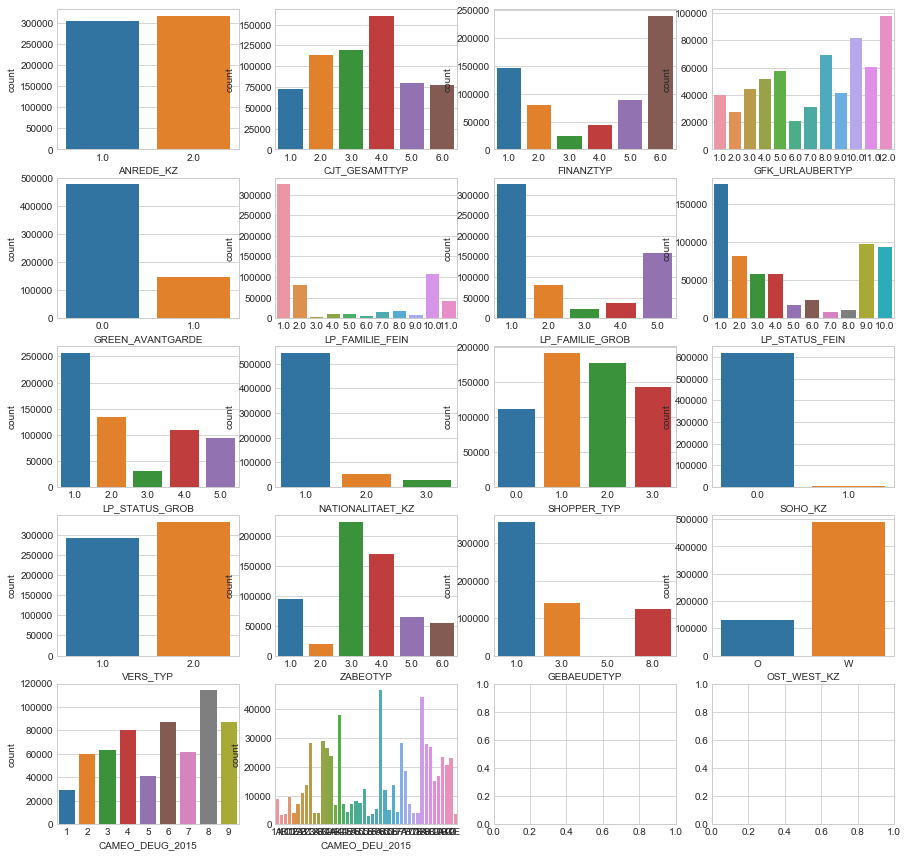

In [52]:
row = 5
col = 4
fig, ax = plt.subplots(nrows = row, ncols = col, figsize = (15,15))
index = 0

for i in range(row): 
    for j in range(col): 
        if index <len(cat_list):
            sns.countplot(x=cat_list[index],data=azdias_clean, ax=ax[i][j])
            index = index + 1

fig.show()

By observing the aboved graphs, we see the following: 

1. Binary (two-level) categoricals that take numeric values, we will simply them without needing to do anything. 
    - **ANREDE_KZ**: use get_dummies()
    - **GREEN_AVANTGARDE**: use get_dummies()
    - **SOHO_KZ**: heavily skewed, drop it. 
    - **VERS_TYP**: use get_dummies()


2. There is one binary variable that takes on non-numeric values. 
    - **OST_WEST_KZ (Keep)**: Use get_dummies() 


3. For multi-level categoricals (three or more values), we have 13 features. We keep 8, drop 5. Reason below: 
    - **CJT_GESAMTTYP (Keep, encoding):** 6 values, use get_dummies to do encoding
    - **FINANZTYP (Keep, encoding):** 6 values, use get_dummies to do encoding. (Addional thought: This is summary for all the FINANZ_ features. Since we already have FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER in our dataset. we can delete this feature.)
    - **GFK_URLAUBERTYP (Keep, encoding):** 12 values, use get_dummies. (Too many categories. Drop it for now)
    - **LP_FAMILIE_FEIN (Delete):** 11 values. This is a family type feature. We have other features that with similar information, such as the LP_FAMILIE_GROB feature. We can drop the LP_FAMILIE_FEIN feature for now. Plus it's very skewed.
    - **LP_FAMILIE_GROB (Keep, encoding):** 5 values, use get_dummies(). (Family type,5 values. Since CAMEO_INTL_2015 feature has similar information, we will detele LP_FAMILIE_GROB for now.) 
    - **LP_STATUS_FEIN (Delete):** 10 values. This is similar to LP_STATUS_GROB, but in a fine scale. WE can drop it for now. 
    - **LP_STATUS_GROB (Keep, encoding):** social status, 5 values. get_dummies to do encoding
    - **NATIONALITAET_KZ (Keep, encoding):** 3 values. get_dummies to do encoding
    - **SHOPPER_TYP (Keep, encoding):** 4 values. get_dummies to do encoding
    - **ZABEOTYP (Keep, encoding):** Energy consumption, 7 values. get_dummies to do encoding
    - **GEBAEUDETYP (Delete):** 4 values in this dataset, but can have up to 10 values avaliable. Delete for now. 
    - **CAMEO_DEUG_2015 (Delete):** 9 values. We have a mix type feature called CAMEO_INTL_2015 that have similar information but with less values. So we will drop CAMEO_DEUG_2015 for now
    - **CAMEO_DEU_2015 (Delete):** Wealth / Life Stage Typology, detailed scale. We have CAMEO_INTL_2015 that have similar information but with less values. So we will drop CAMEO_DEU_2015 for now

In [53]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [54]:
bi_col = ['ANREDE_KZ','GREEN_AVANTGARDE','VERS_TYP']

In [55]:
azdias_clean = pd.get_dummies(azdias_clean, columns = bi_col, drop_first=True)

In [56]:
# drop SOHO_KZ
azdias_clean.drop('SOHO_KZ',axis = 1, inplace=True)

In [57]:
# for feature OST_WEST_KZ: use get_dummies()
azdias_clean = pd.get_dummies(azdias_clean, columns = ['OST_WEST_KZ'], drop_first=True)

In [58]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_2.0,GREEN_AVANTGARDE_1.0,VERS_TYP_2.0,OST_WEST_KZ_W
1,1.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1,0,1,1
2,3.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,...,1.0,4.0,4.0,3.0,5.0,2.0,1,1,0,1
4,3.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,0,1,1
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1,0,1,1
6,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,12.0,...,1.0,5.0,5.0,4.0,6.0,3.0,1,0,0,1


In [59]:
azdias_clean['OST_WEST_KZ_W'].value_counts()

1    490879
0    132330
Name: OST_WEST_KZ_W, dtype: int64

In [60]:
# For multi-level categoricals (three or more values), we keep the following: 
multi_col = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
             'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP' ]

In [61]:
azdias_clean[multi_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 8 columns):
CJT_GESAMTTYP       623209 non-null category
FINANZTYP           623209 non-null category
GFK_URLAUBERTYP     623209 non-null category
LP_FAMILIE_GROB     623209 non-null category
LP_STATUS_GROB      623209 non-null category
NATIONALITAET_KZ    623209 non-null category
SHOPPER_TYP         623209 non-null category
ZABEOTYP            623209 non-null category
dtypes: category(8)
memory usage: 29.5 MB


In [62]:
azdias_clean = pd.get_dummies(azdias_clean, columns = multi_col, drop_first=True)

In [63]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0,0,0,0,1,0,0,0,1,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,0,0,1,0,0,0,0,1,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,0,0,1,0,0,0,1,0,0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,0,0,0,0,1,0,0
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,0,0,1,0,0,0,0,1,0,0


In [64]:
# For multi-level categoricals (three or more values), we drop the 5 following: 
multi_col_drop = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']

azdias_clean.drop(multi_col_drop,axis = 1, inplace=True)

In [65]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0,0,0,0,1,0,0,0,1,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,0,0,1,0,0,0,0,1,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,0,0,1,0,0,0,1,0,0
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,0,0,0,0,1,0,0
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,0,0,1,0,0,0,0,1,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

By observing the aboved graphs, we see the following: 

1. Binary (two-level) categoricals that take numeric values, we will simply them without needing to do anything. 
    - **ANREDE_KZ**: use get_dummies()
    - **GREEN_AVANTGARDE**: use get_dummies()
    - **SOHO_KZ**: heavily skewed, drop it. 
    - **VERS_TYP**: use get_dummies()


2. There is one binary variable that takes on non-numeric values. 
    - **OST_WEST_KZ (Keep)**: Use get_dummies() 


3. For multi-level categoricals (three or more values), we have 13 features. We keep 8, drop 5. Reason below: 
    - **CJT_GESAMTTYP (Keep, encoding):** 6 values, use get_dummies to do encoding
    - **FINANZTYP (Keep, encoding):** 6 values, use get_dummies to do encoding. (Addional thought: This is summary for all the FINANZ_ features. Since we already have FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER in our dataset. we can delete this feature.)
    - **GFK_URLAUBERTYP (Keep, encoding):** 12 values, use get_dummies. (Too many categories. Drop it for now)
    - **LP_FAMILIE_FEIN (Delete):** 11 values. This is a family type feature. We have other features that with similar information, such as the LP_FAMILIE_GROB feature. We can drop the LP_FAMILIE_FEIN feature for now. Plus it's very skewed.
    - **LP_FAMILIE_GROB (Keep, encoding):** 5 values, use get_dummies(). (Family type,5 values. Since CAMEO_INTL_2015 feature has similar information, we will detele LP_FAMILIE_GROB for now.) 
    - **LP_STATUS_FEIN (Delete):** 10 values. This is similar to LP_STATUS_GROB, but in a fine scale. WE can drop it for now. 
    - **LP_STATUS_GROB (Keep, encoding):** social status, 5 values. get_dummies to do encoding
    - **NATIONALITAET_KZ (Keep, encoding):** 3 values. get_dummies to do encoding
    - **SHOPPER_TYP (Keep, encoding):** 4 values. get_dummies to do encoding
    - **ZABEOTYP (Keep, encoding):** Energy consumption, 7 values. get_dummies to do encoding
    - **GEBAEUDETYP (Delete):** 4 values in this dataset, but can have up to 10 values avaliable. Delete for now. 
    - **CAMEO_DEUG_2015 (Delete):** 9 values. We have a mix type feature called CAMEO_INTL_2015 that have similar information but with less values. So we will drop CAMEO_DEUG_2015 for now
    - **CAMEO_DEU_2015 (Delete):** Wealth / Life Stage Typology, detailed scale. We have CAMEO_INTL_2015 that have similar information but with less values. So we will drop CAMEO_DEU_2015 for now

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

/Users/Jiaqi/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


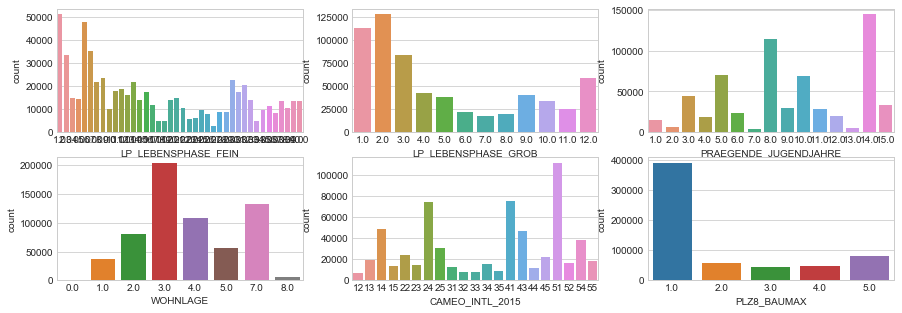

In [66]:
# plot mixed type features
row = 2
col = 3
fig, ax = plt.subplots(nrows = row, ncols = col, figsize = (15,5))
index = 0

for i in range(row): 
    for j in range(col): 
        if index <len(mix_list):
            sns.countplot(x=mix_list[index],data=azdias_clean, ax=ax[i][j])
            index = index + 1

fig.show()

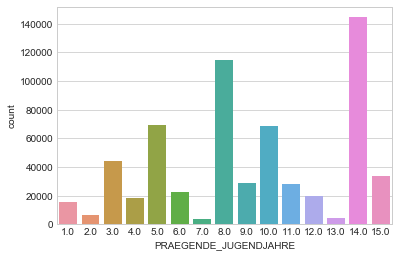

In [67]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sns.countplot(azdias_clean['PRAEGENDE_JUGENDJAHRE'])

We can see data values from 1 to 15. 

1. According to the dictionary, we can map the values by decade as following: 
    - 40: 1 and 2
    - 50: 3 and 4
    - 60: 5, 6, 7
    - 70: 8 and 9
    - 80: 10, 11, 12, 13
    - 90: 14 and 15
    
2. According to the dictionary, we can map the movement (mainstream vs. avantgarde) as following: 
    - Mainstream: 1, 3, 5, 8, 10, 12, 14
    - Avantgarde: 2, 4, 6, 7, 9, 11, 13, 15
    

In [68]:
decade = []
movement = []

for i in range(len(azdias_clean)):
    # map values to decade 
    if azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [1,2]: 
        decade.append(40)
    elif azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [3,4]:   
        decade.append(50)
    elif azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [5,6,7]:   
        decade.append(60)
    elif azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [8,9]:   
        decade.append(70)
    elif azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [10,11,12,13]:   
        decade.append(80)
    elif azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [14,15]:   
        decade.append(90)
    
    # map movement: 
    if azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [1, 3, 5, 8, 10, 12, 14]: 
        movement.append(1)
    elif azdias_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [2, 4, 6, 7, 9, 11, 13, 15]: 
        movement.append(0)

# assign the two columns to azdias dataset
azdias_clean['decade'] = decade
azdias_clean['movement'] =  movement

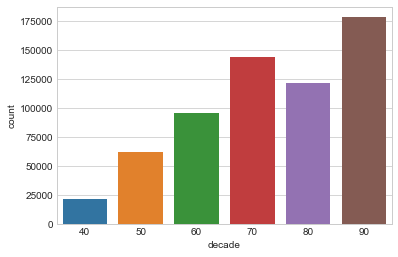

In [69]:
sns.countplot(azdias_clean['decade'])

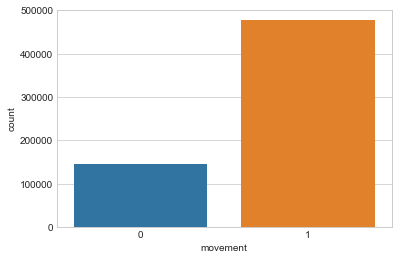

In [70]:
sns.countplot(azdias_clean['movement'])

In [71]:
# drop 'PRAEGENDE_JUGENDJAHRE' after finishing feature engineering
azdias_clean.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

In [72]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decade,movement
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0,0,1,0,0,0,1,0,90,1
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,1,0,0,0,0,1,0,90,0
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,1,0,0,0,1,0,0,70,1
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,0,0,1,0,0,50,1
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,1,0,0,0,0,1,0,0,80,1


**Investigate "CAMEO_INTL_2015" and engineer two new variables.**

Looking at the **CAMEO_INTL_2015** feature:

- the 'tens' place represents wealth status:
    - 1 = Wealthy
    - 2 = Prosperous
    - 3 = Comfortable
    - 4 = Less Affluent
    - 5 = Poorer

- the 'ones' place represents life state: 
    - 1 = Pre-Family Couples & Singles
    - 2 = Young Couples With Children
    - 3 = Families With School Age Children
    - 4 = Older Families & Mature Couples
    - 5 = Elders In Retirement


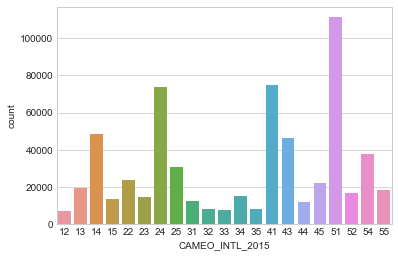

In [73]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sns.countplot(azdias_clean['CAMEO_INTL_2015'])

In [74]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_list = []
life_list = []

for i in range(len(azdias_clean)):
    # change tens place variable
    wealth_list.append(int(str(azdias_clean['CAMEO_INTL_2015'].iloc[i])[0]))
    
    # change ones place variable
    life_list.append(int(str(azdias_clean['CAMEO_INTL_2015'].iloc[i])[1]))

azdias_clean['CAMEO_INTL_2015_Wealth'] = wealth_list
azdias_clean['CAMEO_INTL_2015_Life'] = life_list

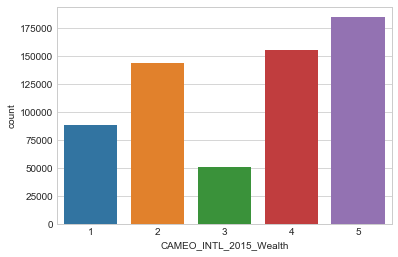

In [75]:
sns.countplot(azdias_clean['CAMEO_INTL_2015_Wealth'])

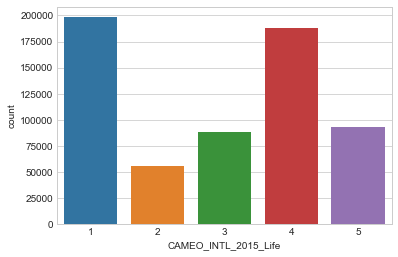

In [76]:
sns.countplot(azdias_clean['CAMEO_INTL_2015_Life'])

In [77]:
# drop 'CAMEO_INTL_2015' after finishing feature engineering
azdias_clean.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

In [78]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decade,movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,1,0,0,0,1,0,90,1,5,1
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0,0,0,0,1,0,90,0,2,4
4,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0,0,0,1,0,0,70,1,4,3
5,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0,0,0,1,0,0,50,1,5,4
6,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,0,0,0,1,0,0,80,1,2,2


Take a look at other mix-typed features and see if we should keep them or delete them. 

In [79]:
mix_list

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

- **LP_LEBENSPHASE_FEIN (Delete)**: This is life stage in fine scale. Information about life stage status, such as single, married etc. It also contains income status, such as low-income, average earners etc. Actually, in the previous analysis, we use **'CAMEO_INTL_2015'** to create two variables, which are life stage and wealth status. I think we can drop this **LP_LEBENSPHASE_FEIN** mix-typed feature. 

- **LP_LEBENSPHASE_GROB (Delete)**: Similar to the above reason, it's similar to the new variables we created. So I think we can drop this mix-typed feature. 

- **PRAEGENDE_JUGENDJAHRE (Done)**: We already did feature engineering for this feature. 

- **WOHNLAGE (Delete)**: Neighborhood quality (or rural flag). For the purpose of this exercise, I'm going to delete it.

- **CAMEO_INTL_2015 (Done)**: We already did feature engineering for this feature. 

- **PLZ8_BAUMAX (Delete)**: The data is very skewed to right, I think we can delete it.  

In [80]:
# drop LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB and 'PLZ8_BAUMAX'
azdias_clean.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 6 mixed-type features originally in the dataset. For each of them, I do the following: 

- **LP_LEBENSPHASE_FEIN (Delete)**: This is life stage in fine scale. Information about life stage status, such as single, married etc. It also contains income status, such as low-income, average earners etc. Actually, in the previous analysis, we use **'CAMEO_INTL_2015'** to create two variables, which are life stage and wealth status. I think we can drop this **LP_LEBENSPHASE_FEIN** mix-typed feature. 

- **LP_LEBENSPHASE_GROB (Delete)**: Similar to the above reason, it's similar to the new variables we created. So I think we can drop this mix-typed feature. 

- **PRAEGENDE_JUGENDJAHRE (Done)**: We already did feature engineering for this feature. 

- **WOHNLAGE (Delete)**: Neighborhood quality (or rural flag). For the purpose of this exercise, I'm going to delete it.

- **CAMEO_INTL_2015 (Done)**: We already did feature engineering for this feature. 

- **PLZ8_BAUMAX (Delete)**: The data is very skewed to right, I think we can delete it.  



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset. (Done)
- Binary categorical features (all numerically-encoded). (Done) 
- Engineered features from other multi-level categorical features and mixed features. (Done)

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [81]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# check if all categorical and mixed-type features are dropped from the dataset
drop_list = cat_list + mix_list

for i in drop_list: 
    if i in azdias_clean.columns: 
        print("Check ", i, " to see if it needs to be dropped")
    else: 
        print(i, " has been dropped.")

ANREDE_KZ  has been dropped.
CJT_GESAMTTYP  has been dropped.
FINANZTYP  has been dropped.
GFK_URLAUBERTYP  has been dropped.
GREEN_AVANTGARDE  has been dropped.
LP_FAMILIE_FEIN  has been dropped.
LP_FAMILIE_GROB  has been dropped.
LP_STATUS_FEIN  has been dropped.
LP_STATUS_GROB  has been dropped.
NATIONALITAET_KZ  has been dropped.
SHOPPER_TYP  has been dropped.
SOHO_KZ  has been dropped.
VERS_TYP  has been dropped.
ZABEOTYP  has been dropped.
GEBAEUDETYP  has been dropped.
OST_WEST_KZ  has been dropped.
CAMEO_DEUG_2015  has been dropped.
CAMEO_DEU_2015  has been dropped.
LP_LEBENSPHASE_FEIN  has been dropped.
LP_LEBENSPHASE_GROB  has been dropped.
PRAEGENDE_JUGENDJAHRE  has been dropped.
WOHNLAGE  has been dropped.
CAMEO_INTL_2015  has been dropped.
PLZ8_BAUMAX  has been dropped.


In [82]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 102 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_Life
dtypes: float64(55), int64(4), uint8(43)
memory usage: 330.8 MB


**Up to this point, we know all mixed-type and categorical type have been feature engineered, and they are also beening drop out of the dataset.**

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [83]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Step 0: Load in the feature summary file to find missing value patterns
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # get missing values list
    missing_value_codes = feat_info.iloc[:,3]
    
    # find missing value list 
    excl = "[]"
    missing_value_list = []
    
    for i in range(len(missing_value_codes)):
        for char in excl: 
            missing_value_codes[i] = missing_value_codes[i].replace(char,"")
            c = missing_value_codes[i].split(',')
   
        missing_value_list.append(c)
 
    # Step 1.1.1: Convert Missing Value Codes and empty values to NaNs
    for i in range(len(feat_info)):
        if df.iloc[:,i].dtype == 'int64':
            df.iloc[:,i] = df.iloc[:,i].astype(float)
    
    for i in range(len(feat_info)):
        if (df.iloc[:,i].dtype == float) and (missing_value_list[i] !=['']):
            c = [float(j) for j in missing_value_list[i]]
            df.iloc[:,i] = df.iloc[:,i].replace(c, np.nan)
        else:
            c = [str(j) for j in missing_value_list[i]]
            df.iloc[:,i] = df.iloc[:,i].replace(c, np.nan)
        
    # replace any empty value to NaNs
    df = df.fillna(np.nan)
    
    # Step 1.1.2: Assess Missing Data in Each Column, delete top 6 columns with more than 30% missing values
    drop_cols = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

    # drop those columns in the datast
    df.drop(drop_cols,axis = 1, inplace = True)
    
    # Step 1.1.3: Assess Missing Data in Each Row, delete any rows with missing values
    # step a: get number of missing values in each row
    row_nans = pd.Series(data = df.isnull().sum(axis=1), name = 'num_nans')
    
    # step b: append row_nans indicator to input dataset
    df['row_nans_num'] = row_nans
    
    # step c: divide input dataset into two subsets. 
    # One is no missing values in a row, that's row_nans_num == 0
    # One is with at least one missing value in a row, that's row_nans_num > 0

    def f(row):
        if row['row_nans_num'] == 0:
            val = 'N'
        else:
            val = 'Y'
        return val

    df['row_nans_id'] = df.apply(f, axis=1)
    
    #df_no_rownans = df[df['row_nans_id'] == 'N']
    #df_has_rownans = df[df['row_nans_id'] == 'Y']
    
    # For the purpose of this analysis, I'm going to drop the rows with missing values in the dataset.
    df_clean = df[df['row_nans_id'] == 'N'].copy()
    
    # output rows with missing values to set it aside as another cluster
    df_row = df[df['row_nans_id'] == 'Y'].copy()
    
    # drop the two columns I added in the previous analysis
    df_clean.drop(['row_nans_num','row_nans_id'],axis = 1, inplace = True)    
 
    # Step 1.2: Select and Re-Encode Features
    
    # Re-Encode categorical and mixed-type features
    
    # Step 1.2.0: get categorical features and mixed-type features
    cat_feature = []
    for i, name in enumerate(feat_info[feat_info.type == 'categorical']['attribute']):
        cat_feature.append(name)
    
    # some of the features were removed fromp previous steps. So for encoding, we only need to do for the ones that's 
    # in our dataset
    cat_list = []
    for i in range(len(cat_feature)):
        if cat_feature[i] in df_clean.columns: 
            cat_list.append(cat_feature[i])
            
    # stored mixed type feature column names into a list
    mix_feature = []
    for i, name in enumerate(feat_info[feat_info.type == 'mixed']['attribute']):
        mix_feature.append(name)
            
    # some of the features were removed fromp previous steps. So for encoding, we only need to do for the ones that's 
    # in our dataset
    mix_list = []
    for i in range(len(mix_feature)):
        if mix_feature[i] in df_clean.columns: 
            mix_list.append(mix_feature[i])    

    # Step 1.2.1: Re-Encode Categorical Features
    # make sure all the categorical features have dtype = category
    for i in range(len(cat_list)):
        df_clean[cat_list[i]] = df_clean[cat_list[i]].astype('category')
    
    # get_dummies for 'ANREDE_KZ','GREEN_AVANTGARDE','VERS_TYP' 
    bi_col = ['ANREDE_KZ','GREEN_AVANTGARDE','VERS_TYP']
    df_clean = pd.get_dummies(df_clean, columns = bi_col, drop_first=True)
    
    # drop SOHO_KZ due to skeweness
    df_clean.drop('SOHO_KZ',axis = 1, inplace=True)
    
    # for feature OST_WEST_KZ: use get_dummies()
    df_clean = pd.get_dummies(df_clean, columns = ['OST_WEST_KZ'], drop_first=True)
 
    # For multi-level categoricals (three or more values), we keep the following: 
    multi_col = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_GROB','LP_STATUS_GROB',
                 'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP' ]
    df_clean = pd.get_dummies(df_clean, columns = multi_col, drop_first=True)
    
    # For multi-level categoricals (three or more values), we drop the 5 following: 
    multi_col_drop = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']

    df_clean.drop(multi_col_drop,axis = 1, inplace=True)
    
    # Step 1.2.2: Engineer Mixed-Type Features
    
    #Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    decade = []
    movement = []

    for i in range(len(df_clean)):
        # map values to decade 

        if df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [1,2]: 
            decade.append(40)
        elif df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [3,4]:   
            decade.append(50)
        elif df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [5,6,7]:   
            decade.append(60)
        elif df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [8,9]:   
            decade.append(70)
        elif df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [10,11,12,13]:   
            decade.append(80)
        elif df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [14,15]:   
            decade.append(90)
    
        # map movement: 
        if df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [1, 3, 5, 8, 10, 12, 14]: 
            movement.append(1)
        elif df_clean['PRAEGENDE_JUGENDJAHRE'].iloc[i] in [2, 4, 6, 7, 9, 11, 13, 15]: 
            movement.append(0)

    # assign the two columns to azdias dataset
    df_clean['decade'] = decade
    df_clean['movement'] =  movement
    
    # drop 'PRAEGENDE_JUGENDJAHRE' after finishing feature engineering
    df_clean.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    wealth_list = []
    life_list = []

    for i in range(len(df_clean)):
        # change tens place variable
        wealth_list.append(int(str(df_clean['CAMEO_INTL_2015'].iloc[i])[0]))
    
        # change ones place variable
        life_list.append(int(str(df_clean['CAMEO_INTL_2015'].iloc[i])[1]))

    df_clean['CAMEO_INTL_2015_Wealth'] = wealth_list
    df_clean['CAMEO_INTL_2015_Life'] = life_list
        
    # drop 'CAMEO_INTL_2015' after finishing feature engineering
    df_clean.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)
    
    # Drop other mix-typed features 
    # drop LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB and 'PLZ8_BAUMAX', 'WOHNLAGE'
    df_clean.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 1, inplace=True)
    
   # for i in range(len(df.columns)):
   #     if df.iloc[:,i].dtype == 'uint8':
   #         df.iloc[:,i] = df.iloc[:,i].astype(float)
        
    # Return the cleaned dataframe, dataset with row missing value, dataset with only columns removed
    return df_clean, df_row, df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [84]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_clean.isnull().values.any()

False

Checked! No NaN values. 

In [85]:
# Apply feature scaling to the general population demographics data.
ss = p.StandardScaler()
azdias_ss = ss.fit_transform(azdias_clean) # Fit and transform the data

In [86]:
azdias_ss = pd.DataFrame(azdias_ss) #create a dataframe

In [87]:
azdias_ss.columns = list(azdias_clean.columns) #assign column name from azdias

In [88]:
azdias_ss.head() # check if column is changed

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decade,movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life
0,-1.746291,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,1.044647,-1.665690,0.388387,...,1.835387,-0.181169,-0.746892,-0.609066,2.966187,-0.309311,1.164454,0.553670,1.147882,-1.251108
1,0.202107,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.044647,-0.290654,-0.123872,...,-0.544844,-0.181169,-0.746892,-0.609066,2.966187,-0.309311,1.164454,-1.806129,-0.909997,0.749822
2,0.202107,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,1.044647,1.084382,0.900646,...,-0.544844,-0.181169,-0.746892,1.641858,-0.337133,-0.309311,-0.213400,0.553670,0.461922,0.082845
3,-1.746291,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,1.044647,-0.290654,-1.148389,...,-0.544844,-0.181169,-0.746892,1.641858,-0.337133,-0.309311,-1.591253,0.553670,1.147882,0.749822
4,-0.772092,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.273496,0.396864,-1.148389,...,-0.544844,-0.181169,-0.746892,1.641858,-0.337133,-0.309311,0.475527,0.553670,-0.909997,-0.584131


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I use standardscaler feature scaling method to do feature scaling. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [89]:
# Apply principal component analysis on data
pca = PCA()
X_pca = pca.fit_transform(azdias_ss)

In [90]:
# plot the cumulative and sequential values 
def plot_cumva_sequen(pca, n_comp):
    '''
    pca = model after applying pca 
    n_comp = number for components want to plot in this graph for easy illustration
    '''
# check out the ratio of variance explained by each principal components
# check the cumulative variance explained  
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
    
    plt.figure(figsize = (20,6))
    ax = plt.subplot(111)

    ax.bar(ind[:n_comp],vals[:n_comp])
    ax.plot(ind[:n_comp],cumvals[:n_comp])

    for i in range(len(ind[:n_comp])):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    
    for i in range(len(ind[:n_comp])):
        ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i]+0.2, cumvals[i]), va="bottom", ha="center", fontsize=12)
        
    ax.set_xlabel("Principla Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principla Component, Show First {} Principle Components Here".format(n_comp))

Plot several number of principle components graghs to see at what point little variance is gained by retaining additional eigenvalues.

I choose 10, 15, 20, 25, and 30 components to plot


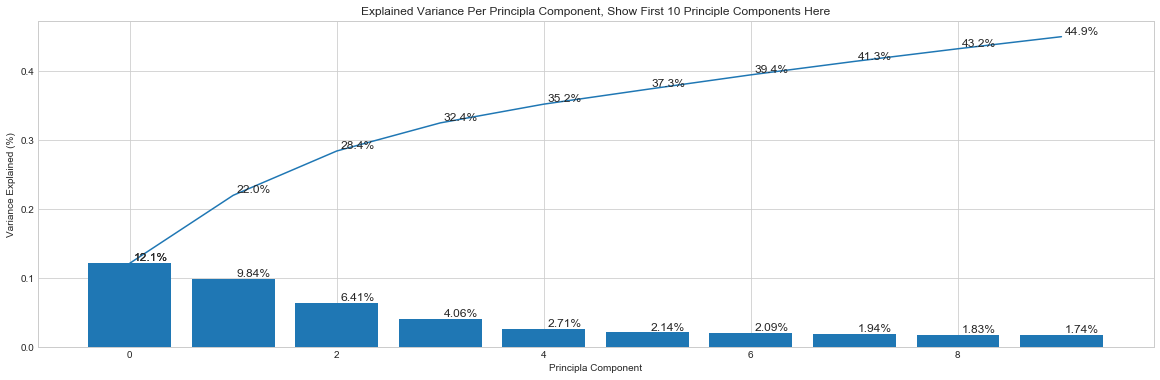

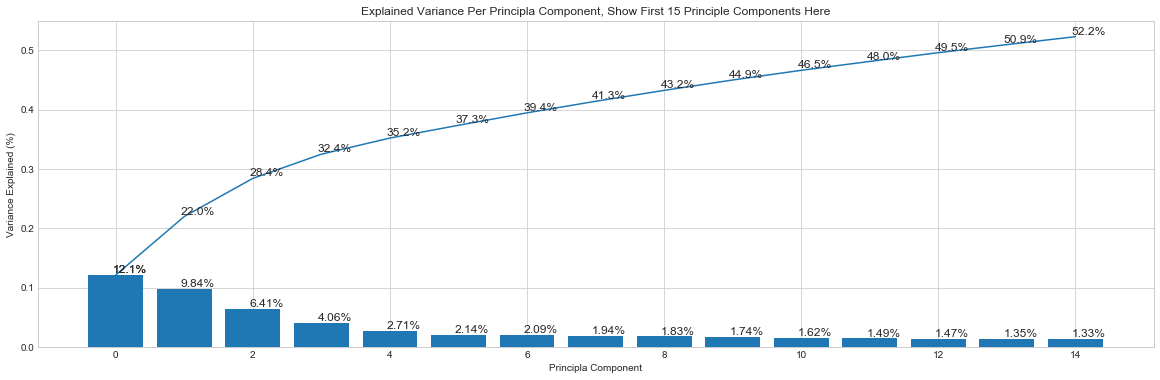

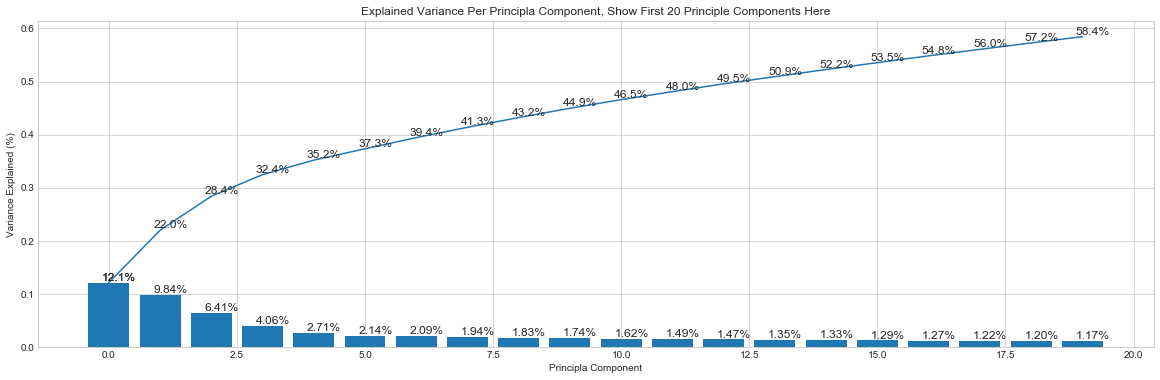

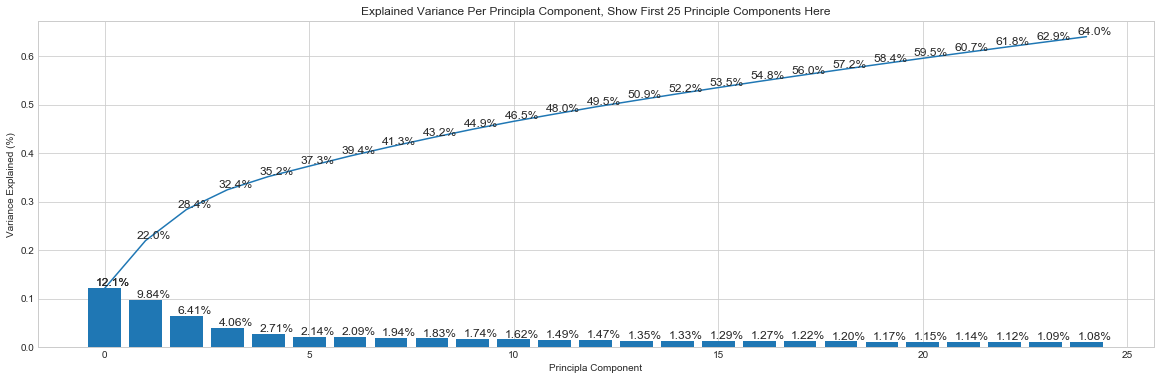

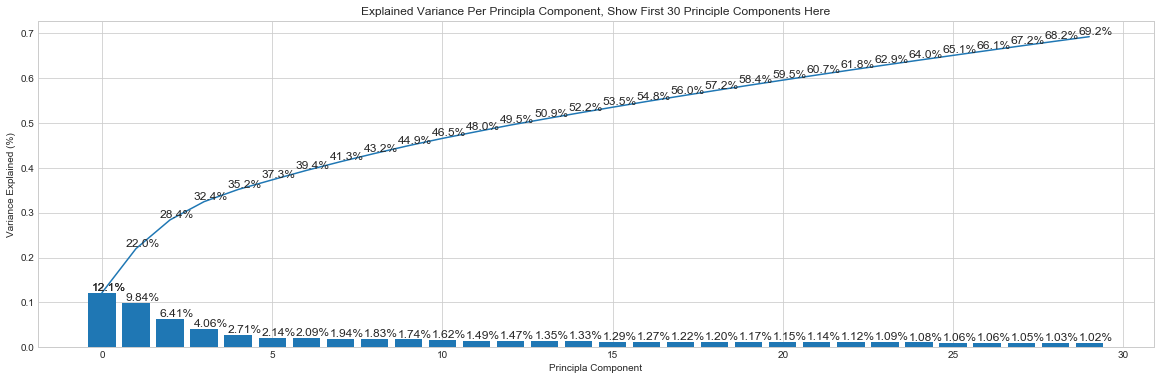

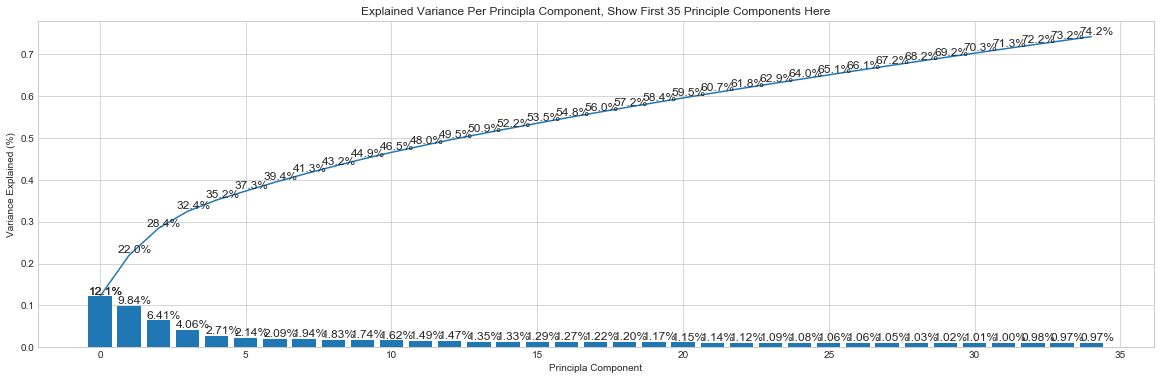

In [91]:
for i in range(10,40,5):
    plot_cumva_sequen(pca,n_comp=i)

From the above charts we can see, after 30 principle components, the variance gained by retaining additional eigenvalues will no more than 1%. For a first try, let's choose number of principle components = 30

In [92]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
X_pca = pca.fit_transform(azdias_ss)

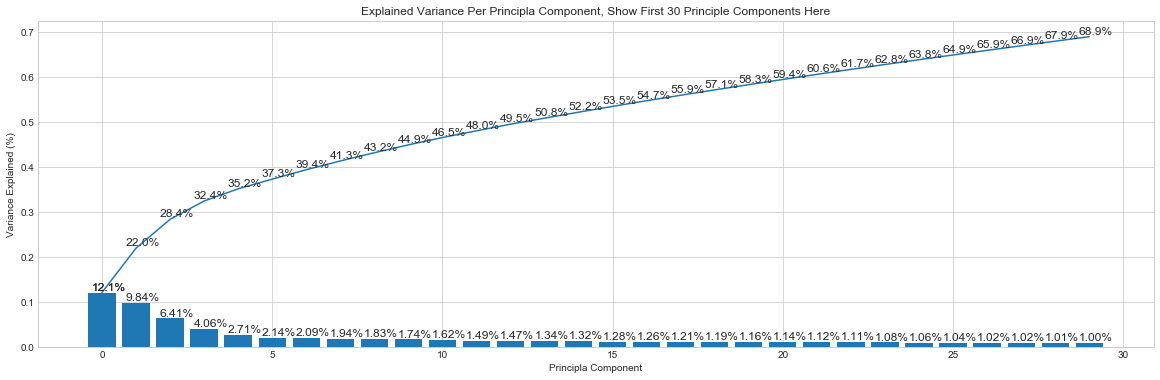

In [93]:
# plot the expained variacen
plot_cumva_sequen(pca, n_comp=30)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Answer:** First I use PCA class to apply apply principal component analysis on the data, thus finding the vectors of maximal variance in the data, without setting any number of principle components. Examinating how varriance is added by retaining additional principal components, I found out that after 30 principle components, no more than 1% of varriance is expained by adding additional principle components. So I decided to keep 30 for a first try. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [94]:
# Dimension indexing
dimensions =  ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_clean.keys())
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

# combine explained variance and PCA components weights together
pca_df = pd.concat([variance_ratios, components], axis = 1)

In [95]:
# create a function to plot the weights for the selected components
def weight_results(dataset, num_comp):
    '''
    Purpose: Map weights for the selected principal component to corresponding feature names 
    Then print the linked values, sorted by weight.
    
    dataset: dataset weith explained variance and PCA components
    num_comp: indicate which component want to displace
    '''
    data = dataset.iloc[num_comp,1:].sort_values(ascending = False)
    
    # create a bar plot visualization
    fig, ax = plt.subplots(figsize = (20,8))
    data.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")
    ax.text(0,ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(pca_df.iloc[num_comp,0]))
    plt.axhline(y= 0.05)
    plt.axhline(y = -0.05)
    plt.title("Feature Weights Distribution for Component {}".format(num_comp+1))
    
    return data.to_frame().transpose()

,FINANZ_SPARER,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,CAMEO_INTL_2015_Wealth,decade,SEMIO_PFLICHT,SEMIO_REL,SEMIO_TRADV,ORTSGR_KLS9,...,SEMIO_LUST,PLZ8_GBZ,SEMIO_ERL,FINANZ_VORSORGER,KBA05_GBZ,PLZ8_ANTG1,ALTERSKATEGORIE_GROB,KBA05_ANTG1,MOBI_REGIO,FINANZ_MINIMALIST
Dimension 1,0.1963,0.1731,0.1727,0.1676,0.1646,0.1645,0.1641,0.1629,0.1515,0.1465,...,-0.129,-0.1303,-0.1313,-0.168,-0.1713,-0.1746,-0.18,-0.1832,-0.1944,-0.22


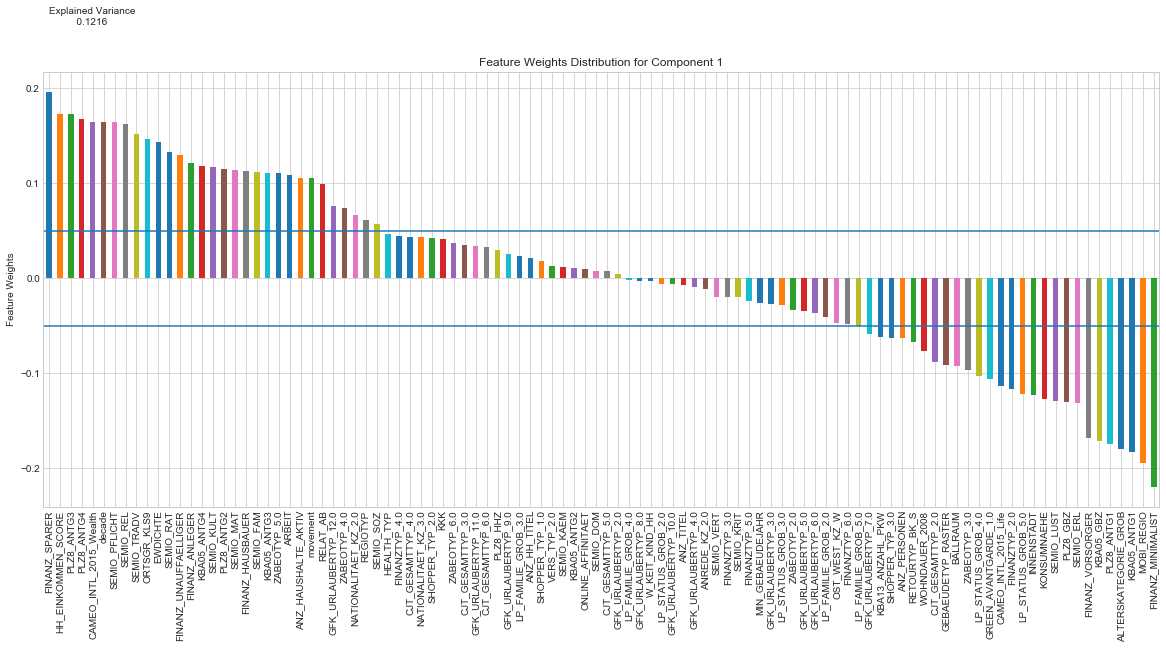

In [96]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
weight_results(pca_df, num_comp=0)

,ALTERSKATEGORIE_GROB,ZABEOTYP_3.0,FINANZ_VORSORGER,SEMIO_ERL,FINANZ_HAUSBAUER,PLZ8_ANTG3,PLZ8_ANTG4,RETOURTYP_BK_S,ORTSGR_KLS9,EWDICHTE,...,SEMIO_KULT,MOBI_REGIO,FINANZ_ANLEGER,FINANZ_SPARER,ONLINE_AFFINITAET,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_UNAUFFAELLIGER,SEMIO_REL,decade
Dimension 2,0.1885,0.1877,0.1725,0.1664,0.1563,0.1553,0.1488,0.145,0.1396,0.1392,...,-0.1566,-0.16,-0.1642,-0.1654,-0.1686,-0.1734,-0.1735,-0.1829,-0.1897,-0.1951


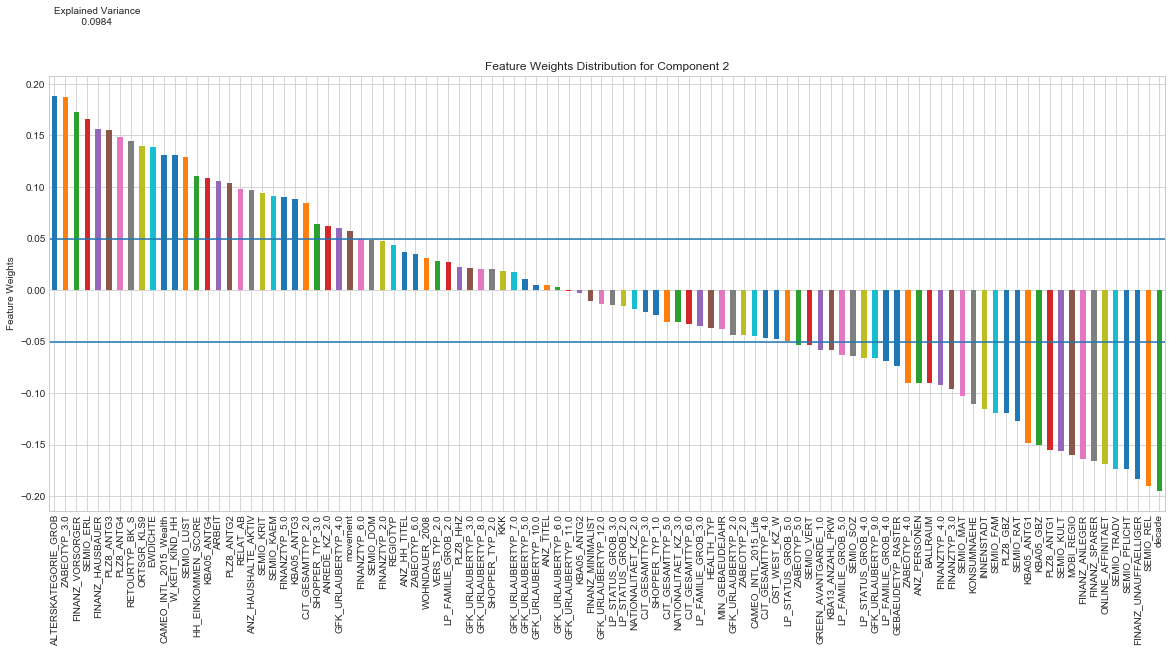

In [97]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_results(pca_df, num_comp=1)

,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZTYP_5.0,FINANZ_MINIMALIST,SEMIO_REL,RETOURTYP_BK_S,W_KEIT_KIND_HH,FINANZ_VORSORGER,...,FINANZ_SPARER,decade,SHOPPER_TYP_2.0,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ_2.0
Dimension 3,0.3387,0.2631,0.2604,0.2436,0.1468,0.1417,0.1024,0.0985,0.0872,0.0732,...,-0.075,-0.0792,-0.1125,-0.1696,-0.186,-0.1899,-0.2668,-0.3016,-0.3317,-0.3599


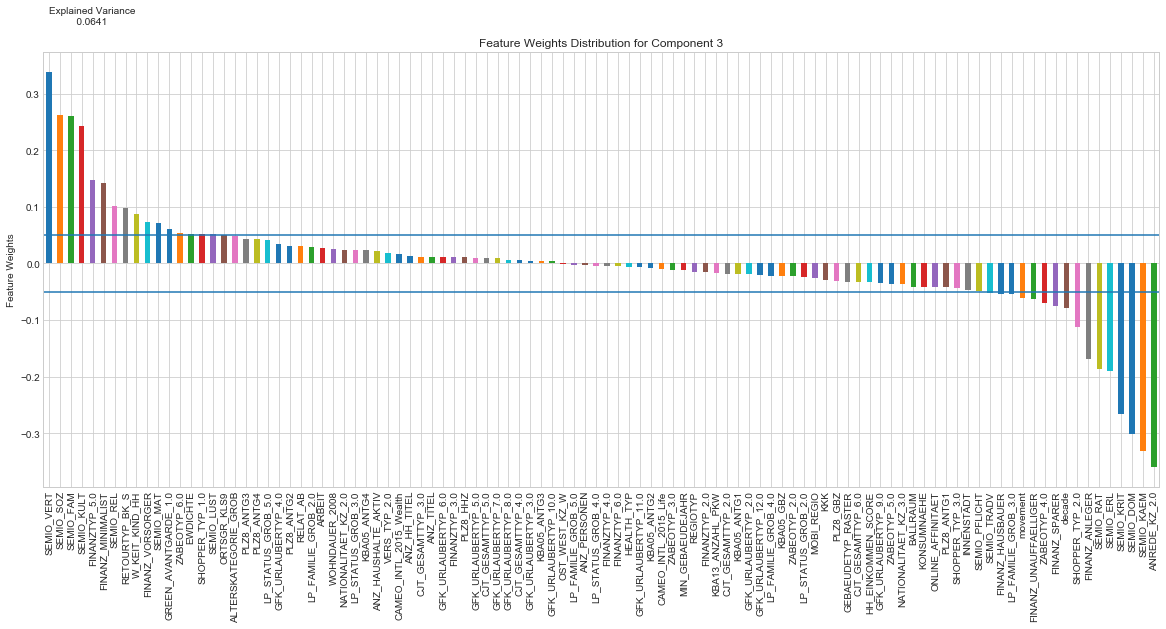

In [98]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_results(pca_df, num_comp=2)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For the first Principle Component: 

1. The top 3 positive features are: 
    - FINANZ_SPARER (Money Saver)
    - HH_EINKOMMEN_SCORE (Estimated household net income)
    - PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)

2. The top 3 negative features are: 
    - FINANZ_MINIMALIST (low financial interest)
    - MOBI_REGIO (Movement pattern)
    - KBA05_ANTG1 (Number of 1-2 family houses in the microcell)

Looks like this is a group of money saver people in a number of 6-10 family houses in the PLZ8 region. Since they are money saver, so they don't have "low financial interest". That's why the FINANZ_MINIMALIST is moving in an opposite direction compare to FINANZ_SPARER. Also, this group is not likely from the number of 1-2 family houses in the microcell region. 

For the second principle component: 
1. The top 3 positive features are: 
    - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
    - ZABEOTYP_3.0 (Energy consumption typology, fair supplied)
    - FINANZ_VORSORGER (financial be prepared)

2. The top 3 negative features are: 
    - decade (age distribution)
    - SEMIO_REL (religious)
    - FINANZ_UNAUFFAELLIGER (inconspicuous)
    
Looks like this group is financially be prepared and have fair supplied of energy consumption. Since they are financially be prepared, so it's less likely financially inconspicuous. Therefore the FINANZ_VORSORGER and FINANZ_UNAUFFAELLIGER is negatively correlated. 

For the third principle component: 
1. The top 3 positive features are: 
    - SEMIO_VERT (dreamful)
    - SEMIO_SOZ	(socially-minded)
    - SEMIO_FAM (family-minded)

2. The top 3 negative features are: 
    - ANREDE_KZ_2.0 (Gender female)
    - SEMIO_KAEM (combative attitude)
    - SEMIO_DOM (dominant-minded)
    
Looks like this group is mostly make up with people with dreamful, socially-minded and family-minded people.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Text(0.5,1,'SSE vs. K')

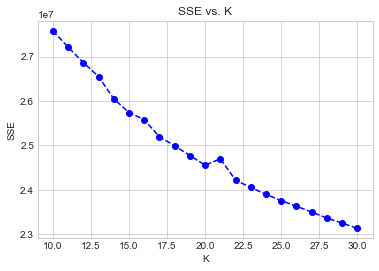

In [301]:
score = []
# Over a number of different cluster counts...
for i in range(10,31):
    kmeans_model = KMeans(n_clusters=i)
    # run k-means clustering on the data and...
    model = kmeans_model.fit(X_pca)
    # compute the average within-cluster distances.
    score.append(np.abs(model.score(X_pca)))

center = list(range(10,31))

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(center, score, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

As we can see from the plot above, SSE is diminishing overall as number of cluster increase. But around 20, there is an increase in terms of SSE. It's a signal of elbow method. I will pick number of cluster = 20 for a try.  

In [99]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_model = KMeans(n_clusters=20)
model = kmeans_model.fit(X_pca)
predictions = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

After ploting number of cluster from 10 to 30, I see overall the SSE is diminishing, but around k =20, there is a little increase after k =20. It gives me a signal that maybe there is a pattern of elbow here. So I choose 20 clusters to segment the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [100]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [101]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [102]:
len(customers)

191652

In [103]:
# Apply the same feature wrangling, selection, and engineering steps to the customer demographics
customers_cleaned, customers_row, customers_col = clean_data(df=customers)

In [104]:
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decade,movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,...,1,0,1,0,0,0,50,0,1,3
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,...,0,0,1,0,0,0,50,0,3,4
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,...,0,0,0,0,0,0,70,1,4,1
5,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,3.0,6.0,...,0,1,0,0,0,0,50,0,3,4
6,4.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,5.0,4.0,...,0,0,0,0,0,0,50,0,2,3


In [105]:
len(customers_cleaned)

115643

In [106]:
print("Customer data missing value portion is:", round(1-len(customers_cleaned)/len(customers),2)*100, "%")

Customer data missing value portion is: 40.0 %


In [107]:
#Apply Feature Scaling
customers_ss = ss.transform(customers_cleaned) # Fit and transform the data
customers_ss = pd.DataFrame(customers_ss) #create a dataframe
customers_ss.columns = list(customers_cleaned.columns) #assign column name from azdias
customers_ss.head() # check if the feature scalling is done

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SHOPPER_TYP_3.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,decade,movement,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life
0,1.176307,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,-1.591638,1.084382,0.900646,...,1.835387,-0.181169,1.338882,-0.609066,-0.337133,-0.309311,-1.591253,-1.806129,-1.595957,0.082845
1,1.176307,1.427283,-1.141401,1.114984,-1.221857,1.047073,0.608140,-0.273496,1.084382,-1.148389,...,-0.544844,-0.181169,1.338882,-0.609066,-0.337133,-0.309311,-1.591253,-1.806129,-0.224038,0.749822
2,0.202107,-0.042471,-1.141401,0.394976,0.848830,1.775773,-0.856545,1.044647,1.084382,-0.123872,...,-0.544844,-0.181169,-0.746892,-0.609066,-0.337133,-0.309311,-0.213400,0.553670,0.461922,-1.251108
3,0.202107,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.124203,1.044647,-0.290654,0.900646,...,-0.544844,5.519715,-0.746892,-0.609066,-0.337133,-0.309311,-1.591253,-1.806129,-0.224038,0.749822
4,1.176307,1.427283,-1.141401,1.114984,-1.221857,-1.139028,-0.856545,-0.273496,1.084382,-0.123872,...,-0.544844,-0.181169,-0.746892,-0.609066,-0.337133,-0.309311,-1.591253,-1.806129,-0.909997,0.082845


In [108]:
len(customers_ss) ==  len(customers_cleaned)

True

In [109]:
#Perform Dimensionality Reduction
customers_pca = pca.transform(customers_ss)

In [110]:
# do the customer prediction
cust_predictions = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [111]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [112]:
import collections

In [113]:
pop_counter = collections.Counter(predictions)
cust_counter = collections.Counter(cust_predictions)

In [114]:
pop_counter = sorted(pop_counter.items())
cust_counter = sorted(cust_counter.items())

In [115]:
labels = ['cluster', 'count']

pop_pred = pd.DataFrame.from_records(pop_counter, columns=labels)
cust_pred = pd.DataFrame.from_records(cust_counter, columns=labels)

In [116]:
# we use the full population length as the denominator to account for the dropped NaNs
pop_pred['percentage'] = pop_pred['count']/891221
pop_pred['Type'] = 'Population'

In [117]:
# we use the full customer length as the denominator to account for the dropped NaNs
cust_pred['percentage'] = cust_pred['count']/len(customers)
cust_pred['Type'] = 'Customers'

In [118]:
result = pop_pred.append(cust_pred)

Text(0.5,1,'Customers')

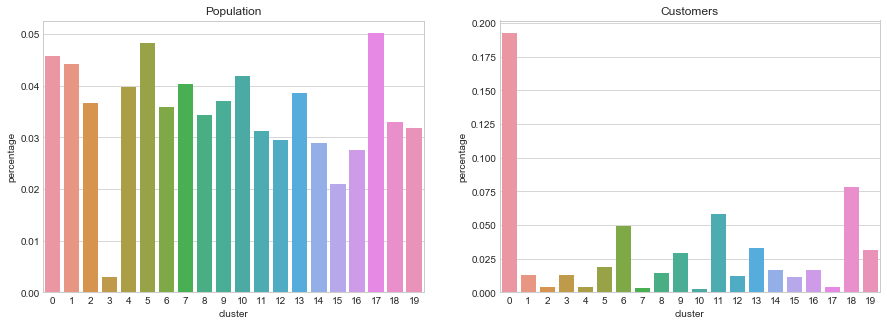

In [119]:
# plot clusters separately
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.barplot(x='cluster',y='percentage', data=result[result['Type']!='Customers'])
plt.title('Population')
plt.subplot(1, 2, 2)
sns.barplot(x='cluster',y='percentage', data=result[result['Type']!='Population'])
plt.title('Customers')

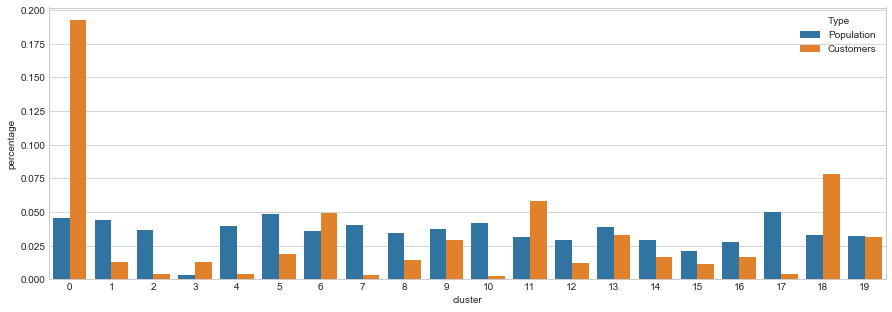

In [120]:
# plot population vs customer side by side
plt.figure(figsize=(15,5))
sns.barplot(x='cluster',y='percentage',hue = 'Type', data=result)

In [121]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# We can see very obviously cluster 0 is overrepresented in the customer data compared to the general population
model.cluster_centers_[0]

# see which principal components contribute to the weight
model.cluster_centers_[0].argsort()[-3:][::-1]

array([ 2,  3, 15])

We can see for cluster 0, the top 3 components are 3,4,16 principal components.

In [122]:
# check the 3rd principal component, find the top 3 positive features
pca_df.iloc[2,1:].sort_values(ascending = False)[:3]

SEMIO_VERT    0.3387
SEMIO_SOZ     0.2631
SEMIO_FAM     0.2604
Name: Dimension 3, dtype: float64

From the 3rd principal component, we can see the top 3 features are all about Personality typology. Looking at the dictionary, we see that: 
- SEMIO_VERT is dreamful
- SEMIO_SOZ is socially-minded
- FAM is family-minded

This means in the customer dataset, the personality typology distribution is very different compared to the demographic dataset. The above type of personality is more representable in the customer dataset. There is a clean change in distribution between two dataset in **Affinity**.

In [123]:
# check the 4th principal component, find the top 3 positive features
pca_df.iloc[3,1:].sort_values(ascending = False)[:3]

GREEN_AVANTGARDE_1.0    0.3551
LP_STATUS_GROB_5.0      0.2728
EWDICHTE                0.2405
Name: Dimension 4, dtype: float64

From the 4th principal component, we can see the top 3 features are about social and financial status. Looking at the dictionary, we see that: 
- GREEN_AVANTGARDE_1 is member of green avantgarde
- LP_STATUS_GROB_5.0 is top earners
- EWDICHTE is Density of households

This means in the customer dataset, the financial and social status distribution is very differnt compared to the demographic dataset. Specifically, the customer data has high weight in top-earners and being member of green avantgarde.

In [124]:
#check the 16th principal component, find the top 3 positive features
pca_df.iloc[15,1:].sort_values(ascending = False)[:3]

BALLRAUM                0.2492
GFK_URLAUBERTYP_12.0    0.2442
LP_STATUS_GROB_5.0      0.2389
Name: Dimension 16, dtype: float64

From the 16th principal component, we see that: 
- LP_STATUS_GROB_5.0 is top earners
- BALLRAUM is Distance to nearest urban center
- GFK_URLAUBERTYP is Vacation habits

This means in the customer dataset, the financial status, household distance to urban center, and the vacation habits are very different compared to the demographic dataset. 

In [128]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# We can see very obviously cluster 2 that is underrepresented in the customer data compared to the generate population
model.cluster_centers_[2]

# see which principal components contribute to the weight
model.cluster_centers_[2].argsort()[-3:][::-1]

array([ 9,  0, 17])

In [130]:
# check the 10th principal component, find the top 3 positive features
pca_df.iloc[9,1:].sort_values(ascending = False)[:3]

SEMIO_RAT        0.2371
OST_WEST_KZ_W    0.2221
SEMIO_TRADV      0.2193
Name: Dimension 10, dtype: float64

From the 10th principal component, we see that:

- SEMIO_RAT is rational
- LP_FAMILIE_GROB_5.0 is family type, multiperson household (maps to 9-11 in fine scale)
- SEMIO_TRADV is tradional-minded

Looks like these three features are less representable in the customer dataset compared to the demographic dataset. Specifically, we see that in the demographic dataset, Building location in the former west Germany with traditional minded personality typology is more representable than in the customer dataset.

In [132]:
# check the 1st principal component, find the top 3 positive features
pca_df.iloc[0,1:].sort_values(ascending = False)[:3]

FINANZ_SPARER         0.1963
HH_EINKOMMEN_SCORE    0.1731
PLZ8_ANTG3            0.1727
Name: Dimension 1, dtype: float64

From the 1st principal component, we see that:

- FINANZ_SPARER is money saver
- HH_EINKOMMEN_SCORE is Estimated household net income
- PLZ8_ANTG3 is Number of 6-10 family houses in the PLZ8 region

Looks like these three features are less representable in the customer dataset compared to the demographic dataset. Specifically, we see that in the demographic dataset, money saver group is overrepresented than in the customer group.

In [133]:
# check the 18th principal component, find the top 3 positive features
pca_df.iloc[17,1:].sort_values(ascending = False)[:3]

CJT_GESAMTTYP_3.0    0.2682
SEMIO_LUST           0.2089
SEMIO_MAT            0.1873
Name: Dimension 18, dtype: float64

From the 18th principal component, we can see the top 3 features are about social and financial status. Looking at the dictionary, we see that:

- CJT_GESAMTTYP_3.0 is advertisinginterested Store-shopper
- SEMIO_LUST is sensual-minded
- SEMIO_MAT is materialistic

Looks like these three features are less representable in the customer dataset compared to the demograpic dataset. Specifically, we see that in the demographic dataset, advertising interested store-shopper is overrepresented than in the customer group. Also, the Personality typology of sensual-minded and materialistic is overrepresented in the demographic dataset than the customer group. 

Notice that I removed all the rows with any missing values in the customer dataset before clustering. I set aside an addiontal cluster to hold data with missing values in rows.

In [175]:
# check how many data I set aside because they have missing value in rows. 
cust_miss = round(len(customers_row)/len(customers_col)*100,2)
print("Percentage of Row With Missing Value in the Customer Dataset is: {}%".format(cust_miss))

Percentage of Row With Missing Value in the Customer Dataset is: 39.66%


In [198]:
customers_row[customers_row.columns[0]].isnull().sum()

240

In [195]:
len(customers_col[customers_row.columns[0]])

191652

In [209]:
round(customers_row[customers_row.columns[0]].isnull().sum()/len(customers_col[customers_row.columns[0]]),4)

0.0013

In [191]:
len(customers_row.columns)

81

In [201]:
customers_row.columns[78]

'RELAT_AB'

In [222]:
miss_percentage=[]
label = []
for i in range(len(customers_row.columns)-2):
    label.append(customers_row.columns[i])
    miss_percentage.append(round(customers_row[customers_row.columns[i]].isnull().sum()/len(customers_col[customers_row.columns[i]]),4))

In [231]:
data_tuples = list(zip(label,miss_percentage))

In [232]:
cust_miss_row = pd.DataFrame(data_tuples, columns=['features','Percentage'])

In [241]:
cust_miss_row[cust_miss_row['Percentage']>0].sort_values(by='Percentage',ascending=False)

,features,Percentage
67,REGIOTYP,0.3134
64,KKK,0.3134
43,W_KEIT_KIND_HH,0.2971
57,KBA05_ANTG3,0.2921
55,KBA05_ANTG1,0.2921
58,KBA05_ANTG4,0.2921
59,KBA05_GBZ,0.2921
65,MOBI_REGIO,0.2921
56,KBA05_ANTG2,0.2921
74,PLZ8_HHZ,0.2753


In [242]:
cust_miss_row[cust_miss_row['Percentage']>0].sort_values(by='Percentage',ascending=False).head(5)

,features,Percentage
67,REGIOTYP,0.3134
64,KKK,0.3134
43,W_KEIT_KIND_HH,0.2971
57,KBA05_ANTG3,0.2921
55,KBA05_ANTG1,0.2921


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the distribution graph above, we can see: 
1. Cluster 0 is overrepresented in the customer dataset. The top principal components are 3, 4, 16. Checking the most positive features for the three principal components, it looks like in the customer dataset, financial status (top earners), distance to urban center and personality typology, Affinity distribution are very different compared to the demographics dataset. The customer dataset is more concentrated in the high finanical income group.
2. We can see the clusters for demographics dataset are more spreadout, indicating that the demographics dataset has a more balanced population. I picked cluster 2, where customer dataset is more underrepresented. The top principal components are 10,1,18. Checking the most positive features for the three principal components, it looks like this cluster is more focus for group with building location in the former west Germany area, money saver in higher density family house area, and advertising interested store-shopper with sensual-minded and materialistic personality typology. 

**It looks like the customer dataset is more focus on certain specific group of people, such as high financial earners, and in urban area. **

**Additionally, for the purpose of this analysis, I dropped any rows with mising data in both the demographic and customer dataset. I separated an additional cluster for accounting held-out data with lots of missing values in customer dataset**
- Recall from **Step 1.1.3: Assess Missing Data in Each Row**, we can see for Azdias dataset, after removing six high missing value columns (TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH), about **69.93%** with no row missing values, and **30.07%** of the data have row missing values. I checked the distribution of all the features, and compared disributions for NaNs and non NaNs dataset, it looks like the majority of the distribution of non-missing features look similar between data with many missing values and the data with no missing values. However, the distribution for two group of features look very different. They are:
    - Features related to financial status, such as Financial type, income etc.
    - Features related to social believes (SEMIO), such as socially-minded, family, religious etc.

- For Customer dataset, after revmoing six high missing value columns (TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH), about **60.34%** with no row missing values, and **39.66%** of the data have row missing values. After checking the customer dataset with high missing values in rows, we can see the top 5 features with high missing values in rows in the customer dataset are: 
    - REGIOTYP (31.34%): Neighborhood type based on income. 
    - KKK (31.34%):Purchasing power. Related to financial status.
    - W_KEIT_KIND_HH (29.71%): Likelihood of children in household.
    - KBA05_ANTG3 (29.21%): Number of 6-10 family houses in the microcell. this is related to housing density.
    - KBA05_ANTG1 (29.21%): Number of 1-2 family houses in the microcell. This is related to housing density as well.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.